<a href="https://colab.research.google.com/github/Abhi10699/google-colab-playground/blob/main/vision_transformer_ViT_weather_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install kaggle
!pip install transformers
!pip install accelerate
!pip install datasets
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.8 MB/s eta 0:00:00


In [ ]:
!mv kaggle.json /root/.kaggle/
!kaggle datasets download -d pratik2901/multiclass-weather-dataset

 84% 77.0M/91.4M [00:00<00:00, 85.7MB/s]
100% 91.4M/91.4M [00:00<00:00, 101MB/s] 


In [ ]:
!unzip multiclass-weather-dataset.zip

Archive:  multiclass-weather-dataset.zip
  inflating: Multi-class Weather Dataset/Cloudy/cloudy1.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy10.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy100.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy101.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy102.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy103.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy104.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy105.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy106.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy107.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy108.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy109.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy11.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy110.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy111.jpg  
  i

## Loading Data

In [ ]:
import os
import pandas as pd
import PIL
import torch


from datasets import load_dataset

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
dataset_path = "Multi-class Weather Dataset"
dataset_dirs = os.listdir(dataset_path)
print(dataset_dirs)

['Rain', 'Shine', 'Sunrise', 'Cloudy']


In [ ]:
dataset = load_dataset("imagefolder", data_dir=f"./{dataset_path}")
dataset = dataset['train'].train_test_split(0.1)
dataset = dataset.shuffle(100)

Resolving data files:   0%|          | 0/1125 [00:00<?, ?it/s]

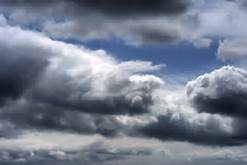

In [ ]:
dataset['test']['image'][0]

In [ ]:
type(dataset)

datasets.dataset_dict.DatasetDict

In [ ]:
label2id = {
    "cloudy": 0,
    "rain": 1,
    "shine": 2,
    "sunrise": 3
}

id2label = {
    0: "cloudy",
    1: "rain",
    2: "shine",
    3: "sunrise"
}

## Preprocessing

In [ ]:
from transformers import AutoImageProcessor
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

In [ ]:
model_ckpt = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(model_ckpt)

In [ ]:
normalize = Normalize(
    mean=image_processor.image_mean,
    std = image_processor.image_std
)

size = (
    image_processor.size['shortest_edge']
    if "shortest_edge" in image_processor.size
    else (image_processor.size['height'], image_processor.size['width'])
)

_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

In [ ]:
def transforms(examples):
  examples['pixel_values'] = [_transforms(img.convert("RGB")) for img in examples['image']]
  del examples["image"]
  return examples

In [ ]:
dataset = dataset.with_transform(transforms)

## Batching

In [ ]:
import evaluate
import numpy as np

from transformers import DefaultDataCollator

In [ ]:
data_collator = DefaultDataCollator()

In [ ]:
accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

## Training

In [ ]:
from transformers import AutoModelForImageClassification, Trainer, TrainingArguments
from huggingface_hub import notebook_login

In [ ]:
notebook_login()

In [ ]:
model = AutoModelForImageClassification.from_pretrained(
    model_ckpt,
    num_labels=len(id2label.keys()),
    id2label=id2label,
    label2id=label2id,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="weather_vit_model",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    num_train_epochs=3,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.119914,0.973451
2,No log,0.128968,0.964602
3,No log,0.110017,0.973451


TrainOutput(global_step=381, training_loss=0.08330229511411172, metrics={'train_runtime': 180.0634, 'train_samples_per_second': 16.861, 'train_steps_per_second': 2.116, 'total_flos': 2.3526989769365914e+17, 'train_loss': 0.08330229511411172, 'epoch': 3.0})

In [ ]:
trainer.push_to_hub()

'https://huggingface.co/abhirajeshbhai/weather_vit_model/tree/main/'

## Inference

In [7]:
# Load model directly
from transformers import AutoFeatureExtractor, AutoModelForImageClassification
from PIL import Image

import torch
import requests

In [3]:
extractor = AutoFeatureExtractor.from_pretrained("abhirajeshbhai/weather_vit_model")
model = AutoModelForImageClassification.from_pretrained("abhirajeshbhai/weather_vit_model")

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


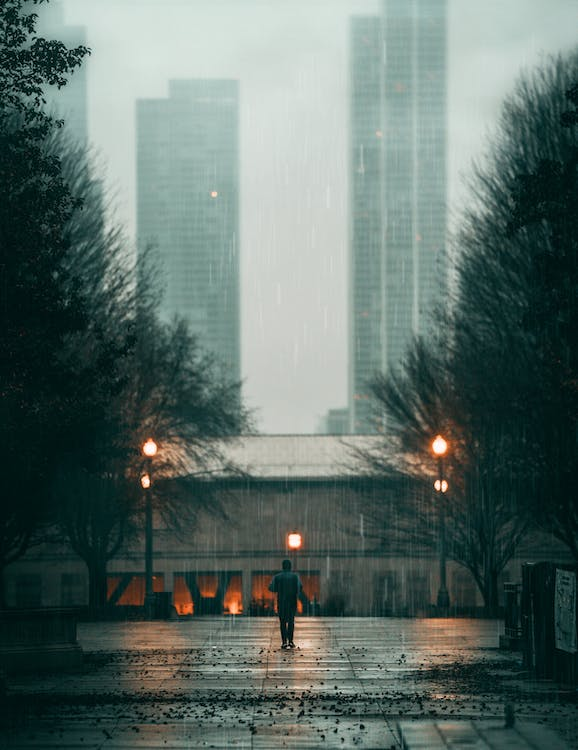

In [12]:
url = "https://images.pexels.com/photos/3617453/pexels-photo-3617453.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1"
image = Image.open(requests.get(url, stream=True).raw)
image

In [23]:
pixel_values = extractor(images=image, return_tensors="pt")

In [24]:
model.eval()
outputs = model(**pixel_values)

In [26]:
predicted_label = outputs.logits.argmax(-1).item()

In [28]:
print(model.config.id2label[predicted_label])

rain
